In [9]:
!pip install opencv-contrib-python==3.4.2.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.6 MB 57.8 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


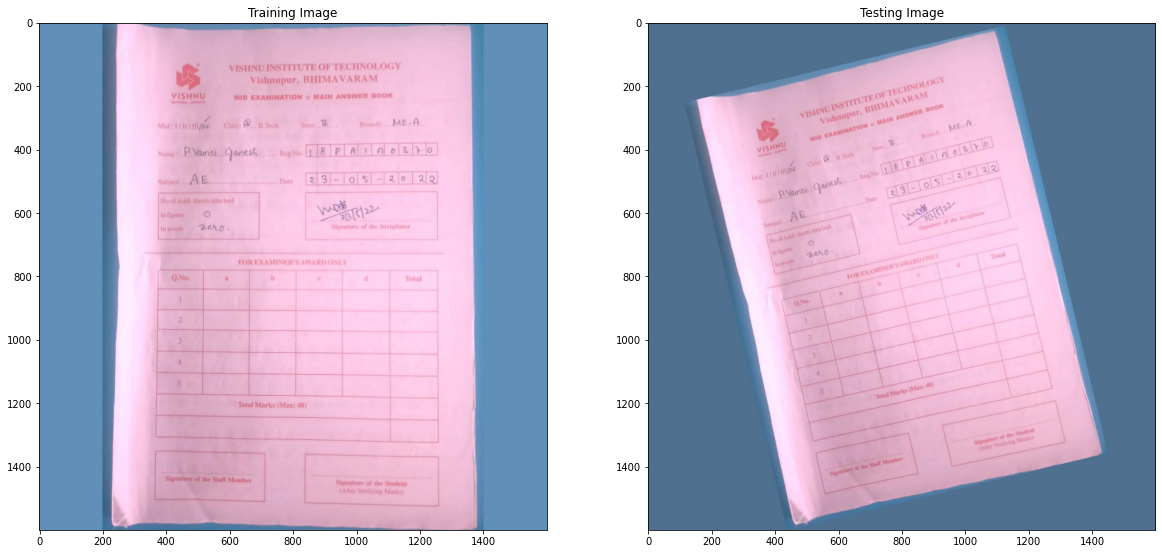

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load the image
image1 = cv2.imread('mid-paper1.jpeg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
# test_image = cv2.pyrDown(training_image)
# test_image = cv2.pyrDown(test_image)
# num_rows, num_cols = test_image.shape[:2]

# rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
# test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))
image2 = cv2.imread('/content/mid-paper2.jpeg')
test_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)

Number of Keypoints Detected In The Training Image:  426
Number of Keypoints Detected In The Query Image:  269


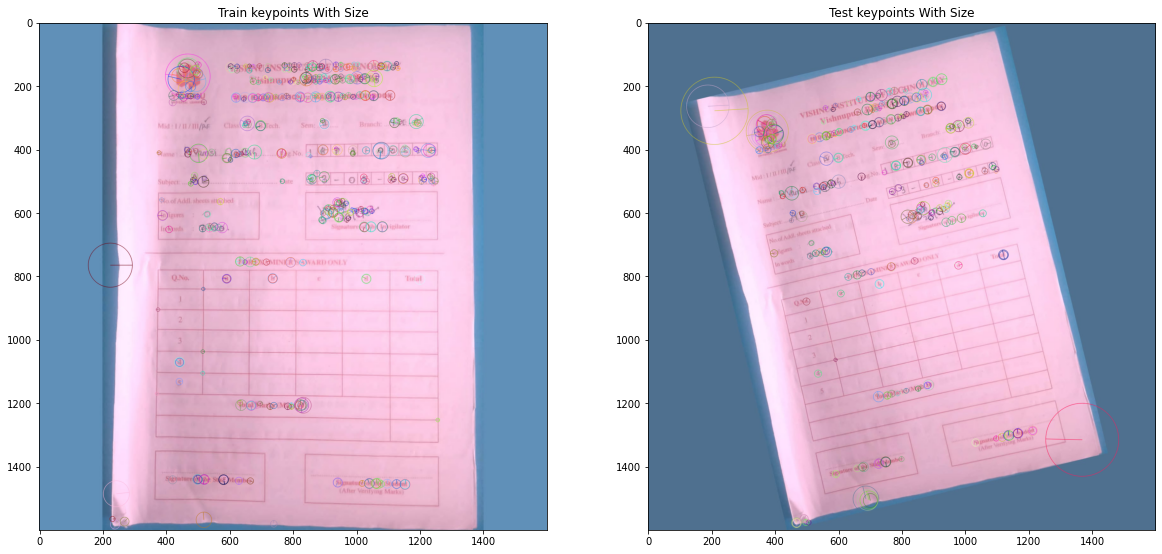

In [9]:
surf = cv2.xfeatures2d.SURF_create(800)

kp1, des1 = surf.detectAndCompute(training_gray, None)
kp2, des2 = surf.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

keypoints_with_size_test = np.copy(test_image)
keypoints_without_size_test = np.copy(test_image)

cv2.drawKeypoints(training_image, kp1, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, kp1, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.drawKeypoints(test_image, kp2, keypoints_with_size_test, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Test keypoints With Size")
plots[1].imshow(keypoints_with_size_test, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(kp1))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(kp2))


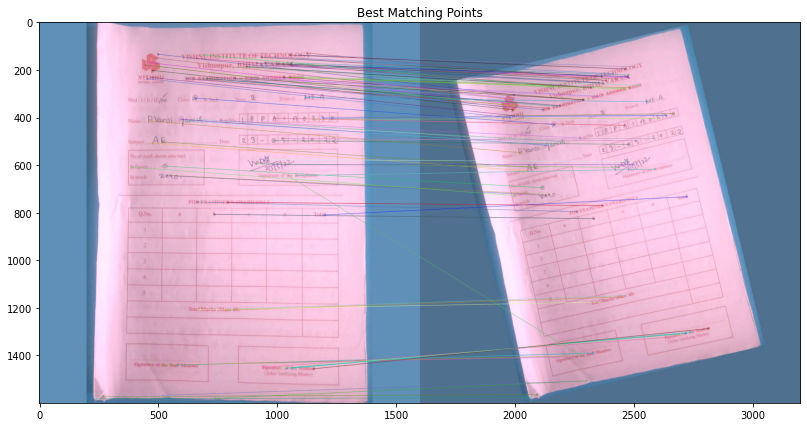


Number of Matching Keypoints Between The Training and Query Images:  426


In [10]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

# Perform the matching between the SURF descriptors of the training image and the test image
matches = bf.match(des1, des2)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, kp1, test_image, kp2, matches[:100], test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))


In [11]:
MIN_MATCH_COUNT = 10

FLANN_INDEX_KDTREE = 1

index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [13]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = training_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(test_image,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

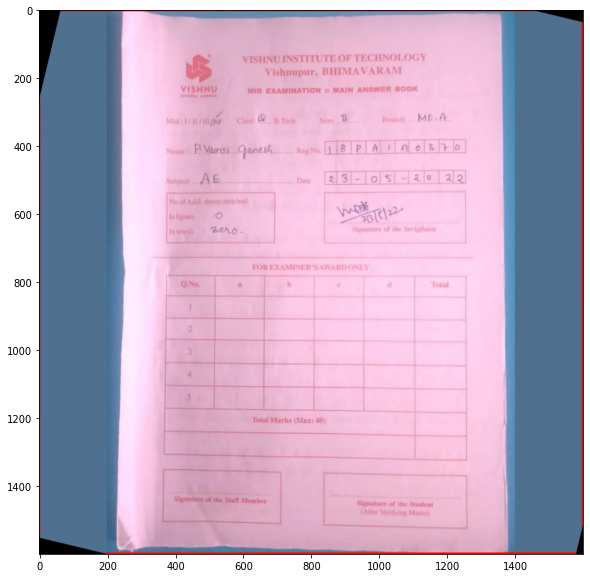

In [14]:
imm = test_image.copy()

matrix = cv.getPerspectiveTransform(dst, pts)

destination_image = cv.warpPerspective(imm, matrix, (1600, 1600))

plt.figure(figsize=(10, 10))

plt.imshow(destination_image)